In [2]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [4]:
def load_from_zip(zip_path, image_size=(64, 64), is_train=True):
    features = []
    labels = []
    filenames = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for file_info in z.infolist():
            if file_info.filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                if is_train:
                    if 'cat' in file_info.filename.lower():
                        label = 0
                    elif 'dog' in file_info.filename.lower():
                        label =1
                    else:
                        continue
                with z.open(file_info) as file:
                    img_data = file.read()
                
                img =cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
                img = cv2.resize(img,image_size)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                


                hog_features = hog(gray,
                               orientations=9,
                               pixels_per_cell=(8, 8),
                               cells_per_block = (2, 2),
                               block_norm='L2-Hys'
                               )
                features.append(hog_features)
                if is_train:
                    labels.append(label)
                else:
                    filenames.append(os.path.basename(file_info.filename))

    if is_train:
        return np.array(features), np.array(labels)
    else:
        return np.array(features), filenames
 


# load data set
X_train, y_train = load_from_zip('train.zip', is_train=True)


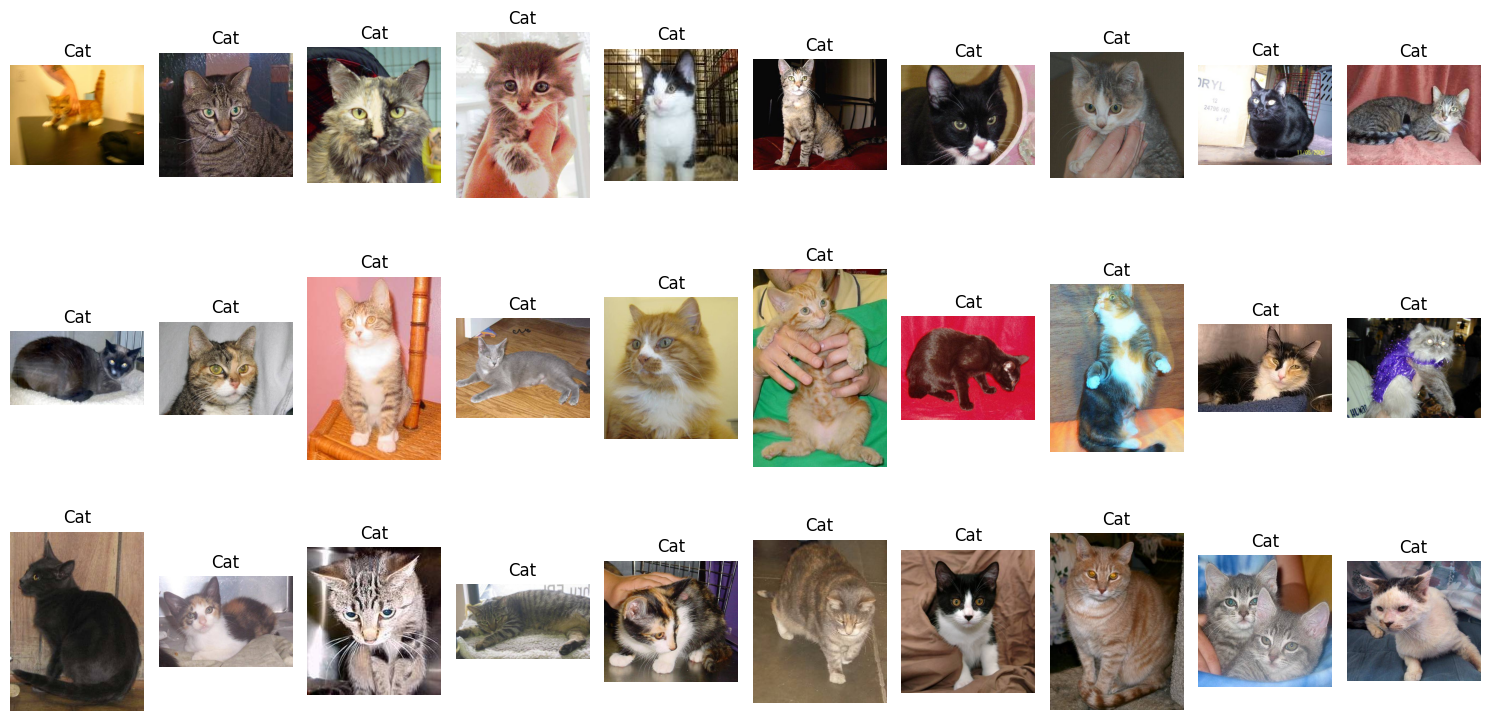

In [5]:
import matplotlib.pyplot as plt

def display_sample_images(zip_path, num_images=10, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    images_to_show = num_images
    rows = 3  # Adjust grid rows/columns as needed
    cols = 10
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Iterate through files and display first 'num_images' samples
        displayed = 0
        for file_info in z.infolist():
            if file_info.filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Extract class label from filename
                if 'cat' in file_info.filename.lower():
                    label = 'Cat'
                elif 'dog' in file_info.filename.lower():
                    label = 'Dog'
                else:
                    continue
                
                # Read image
                with z.open(file_info) as file:
                    img_data = file.read()
                img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
                
                # Plot
                plt.subplot(rows, cols, displayed + 1)
                plt.imshow(img_rgb)
                plt.title(label)
                plt.axis('off')
                
                displayed += 1
                if displayed >= images_to_show:
                    break
        plt.tight_layout()
        plt.show()

# Display 10 sample images from the training ZIP
display_sample_images('train.zip', num_images=30)

In [7]:
#split into training/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#generalize featuer
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
x_val_scaled = scaler.transform(X_val)

#train SVM with Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.1, 1],
    'kernel':['rbf']
}

#svc = SVC(cache_size=2000)
grid = GridSearchCV(SVC(), param_grid, cv=3, verbose=2)
grid.fit(X_train_scaled, y_train)

#validate
best_svm = grid.best_estimator_
val_pred = best_svm.predict(x_val_scaled)
print(f"validation accuracy: {accuracy_score(y_val, val_pred):.2f}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 3.3min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 3.5min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 3.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 5.2min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 5.5min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 5.3min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 9.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 5.3min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 5.3min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 4.8min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 4.6min
[CV] END .......................C=1, gamma=0.001,

In [8]:
from joblib import dump
dump(best_svm,'svm_model.joblib')

dump(scaler,'scaler.joblib')


['scaler.joblib']

In [9]:
#load test data
X_test, test_filenames = load_from_zip('test1.zip', is_train=False)
#preprocess test feature
X_test_scaled = scaler.transform(X_test)
# predict
test_pred = best_svm.predict(X_test_scaled)

In [10]:
#Create submission DataFrame 
submission = pd.DataFrame({
    'id': [f.split('.')[0] for f in test_filenames],
    'label': test_pred
})
# sav to csv
submission.to_csv('sampleSubmission.csv', index=False)

In [16]:
from joblib import load
loaded_svm = load('svm_model.joblib')
loaded_scaler= load('scaler.joblib')

#preprocess new data and predict
def predict_new_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(64, 64))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_hog_features = hog(gray,
                           orientations=9,
                           pixels_per_cell=(8,8),
                           cells_per_block = (2,2),
                           block_norm='L2-Hys'
    )
    scaled_featuuures = loaded_scaler.transform([hog_hog_features])
    prediction = loaded_svm.predict(scaled_featuuures)
    return 'cat' if prediction[0] == 0 else 'dog'

result = predict_new_image("C:/Users/ajmel/Desktop/my_x/Intern/dog.jpeg")
print(f"prediction: {result}")
                        

prediction: dog
